# Proyecto: Clasificación de Desechos Sólidos utilizando DenseNet201

# Nombre: Pedro Arriola
# Carnet: 20188

In [26]:
!pip install -q seaborn

In [27]:
from tensorflow.keras.applications.densenet import DenseNet201, preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
from collections import Counter
import os
import random
import shutil

import warnings
warnings.filterwarnings('ignore')

## EDA

In [28]:
data_path = '/content/drive/MyDrive/Colab_Notebooks/EcoScan/trash'

In [29]:
# Revisa si el path existe y recopila información de las clases
if os.path.exists(data_path):
    # Obtiene los nombres de las clases y cuenta las imágenes en cada clase
    class_names = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name))) for class_name in class_names}
    total_images = sum(class_counts.values())

    # Información resumen
    print("Resumen del conjunto de datos:")
    print(f"Total de clases: {len(class_names)}")
    print(f"Total de imágenes: {total_images}")
    print("Distribución de clases:")
    for class_name, count in class_counts.items():
        print(f"  - {class_name}: {count} imágenes")
else:
    print("La ruta de datos no existe.")

Resumen del conjunto de datos:
Total de clases: 6
Total de imágenes: 4650
Distribución de clases:
  - plastic: 775 imágenes
  - paper: 775 imágenes
  - organic: 775 imágenes
  - metal: 775 imágenes
  - glass: 775 imágenes
  - battery: 775 imágenes


## MODEL CONSTRUCTION

In [30]:
# Parámetros
BATCH_SIZE = 32
n_classes = 6

In [31]:
# Cargar el modelo base preentrenado Xception
conv_base = DenseNet201(
    include_top=False,
    weights='imagenet',
    input_shape=(224, 224, 3)  # Tamaño ajustado a 299x299 para Xception
)

In [32]:
# Congelar todas las capas excepto las dos últimas
for layer in conv_base.layers[:-2]:
    layer.trainable = False

In [33]:
# Valor de la regularización L2 (puedes ajustarlo)
l2_value = 0.002

# Construir el modelo superior (top model) con regularización L2
top_model = conv_base.output
top_model = Flatten(name="flatten")(top_model)
top_model = Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(l2_value))(top_model)  # Regularización L2
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.6)(top_model)
top_model = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(l2_value))(top_model)  # Regularización L2
top_model = BatchNormalization()(top_model)
top_model = Dropout(0.6)(top_model)
output_layer = Dense(n_classes, activation='softmax')(top_model)  # Capa de salida

# Modelo final
model = Model(inputs=conv_base.input, outputs=output_layer)

In [34]:
# Función para mostrar imágenes aleatorias del dataset
def plot_random_images(generator, num_images=20):
    images, labels = next(generator)
    random_indices = np.random.choice(images.shape[0], num_images, replace=False)
    fig, axs = plt.subplots(4, 5, figsize=(15, 12))
    fig.suptitle('Random 20 Images from the Generator', fontsize=16)
    for i, ax in enumerate(axs.flatten()):
        index = random_indices[i]
        image = images[index]
        label = labels[index]
        ax.imshow(image)
        ax.set_title(f'Class: {np.argmax(label)}')
        ax.axis('off')
    plt.show()

## Preparando los datos

In [35]:
undersampled_data_path = '/content/drive/MyDrive/Colab_Notebooks/EcoScan/undersampled_trash'

# Preparar los generadores de datos
original_data = ImageDataGenerator(rescale=1./255).flow_from_directory(
    undersampled_data_path, target_size=(224, 224), batch_size=BATCH_SIZE, class_mode="categorical")
plot_random_images(original_data)

gen_train = ImageDataGenerator(preprocessing_function=preprocess_input)  # Preprocesamiento para Xception
full_data = gen_train.flow_from_directory(undersampled_data_path, target_size=(224, 224), batch_size=BATCH_SIZE, class_mode="categorical")
plot_random_images(full_data)

Output hidden; open in https://colab.research.google.com to view.

In [36]:
# Extraer nombres de archivos y etiquetas
filenames = full_data.filenames
labels = full_data.labels
class_mapping = {value: str(key) for key, value in full_data.class_indices.items()}
labels = [class_mapping[label] for label in labels]

# Dividir en entrenamiento y validación
train_filenames, test_filenames, train_labels, test_labels = train_test_split(
    filenames, labels, test_size=0.1, random_state=42)

# Crear DataFrames para entrenamiento y validación
train_df = pd.DataFrame({'filename': train_filenames, 'class': train_labels})
test_df = pd.DataFrame({'filename': test_filenames, 'class': test_labels})

# Crear generadores de entrenamiento y validación
train_data = gen_train.flow_from_dataframe(
    train_df, directory=undersampled_data_path, target_size=(224, 224),
    batch_size=BATCH_SIZE, class_mode="categorical", shuffle=True, seed=42)

test_data = gen_train.flow_from_dataframe(
    test_df, directory=undersampled_data_path, target_size=(224, 224),
    batch_size=BATCH_SIZE, class_mode="categorical", shuffle=False)

Found 1007 validated image filenames belonging to 6 classes.
Found 112 validated image filenames belonging to 6 classes.


In [37]:
# Definir parámetros del entrenamiento
num_epochs = 50
opt = Adam(learning_rate=0.0001)

In [38]:
# Resumen del modelo
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 115,194,950 (439.43 MB)

 Trainable params: 96,873,734 (369.54 MB)

 Non-trainable params: 18,321,216 (69.89 MB)

In [39]:
# Definir pasos por época
n_steps = train_data.samples // BATCH_SIZE
n_val_steps = test_data.samples // BATCH_SIZE
n_steps, n_val_steps

# Compilar el modelo
model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [40]:
# Callbacks
early = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)

In [41]:
# Entrenar el modelo
result = model.fit(
    train_data,
    epochs=num_epochs,
    validation_data=test_data,
    callbacks=[early, reduce_lr]
)

Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 73s 1s/step - accuracy: 0.4892 - loss: 6.8531 - val_accuracy: 0.8482 - val_loss: 4.5665 - learning_rate: 1.0000e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 175ms/step - accuracy: 0.8587 - loss: 4.2587 - val_accuracy: 0.8839 - val_loss: 3.9135 - learning_rate: 1.0000e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - accuracy: 0.9352 - loss: 3.6125 - val_accuracy: 0.9286 - val_loss: 3.6581 - learning_rate: 1.0000e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - accuracy: 0.9235 - loss: 3.4682 - val_accuracy: 0.9464 - val_loss: 3.5231 - learning_rate: 1.0000e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 178ms/step - accuracy: 0.9480 - loss: 3.3088 - val_accuracy: 0.9464 - val_loss: 3.4638 - learning_rate: 1.0000e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 179ms/step - accuracy: 0.9727 - loss: 3.2261 - val_accuracy: 0.9375 - val_loss: 3.4194 - learning_rate: 1.0000e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - accuracy: 0.

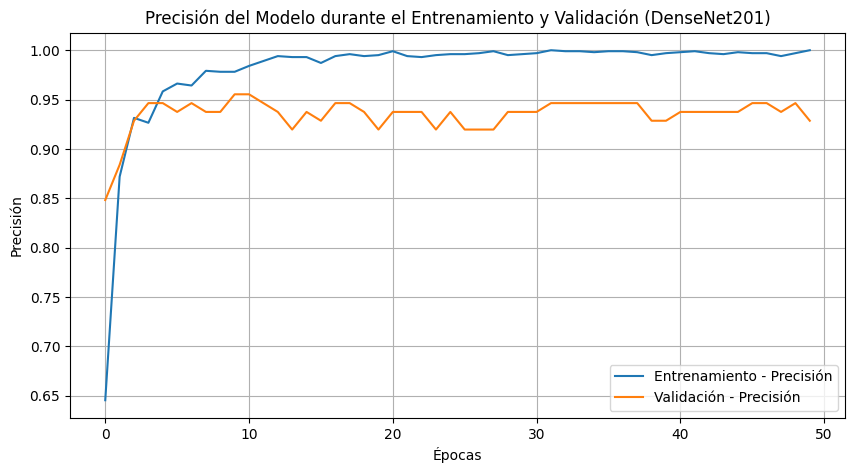

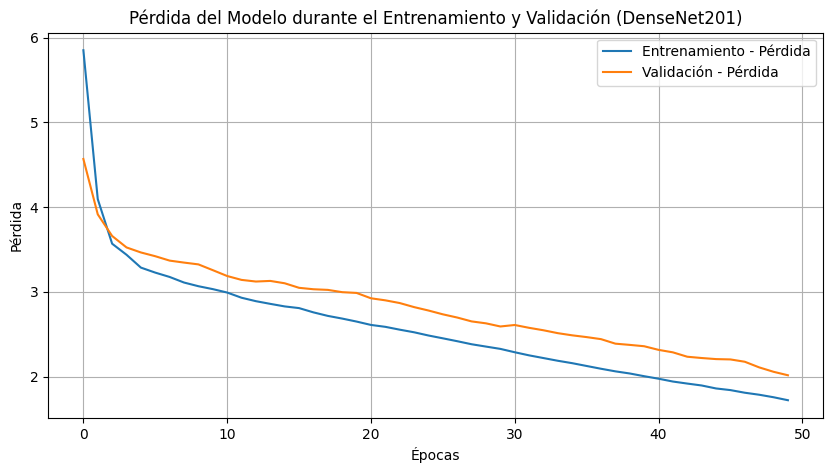

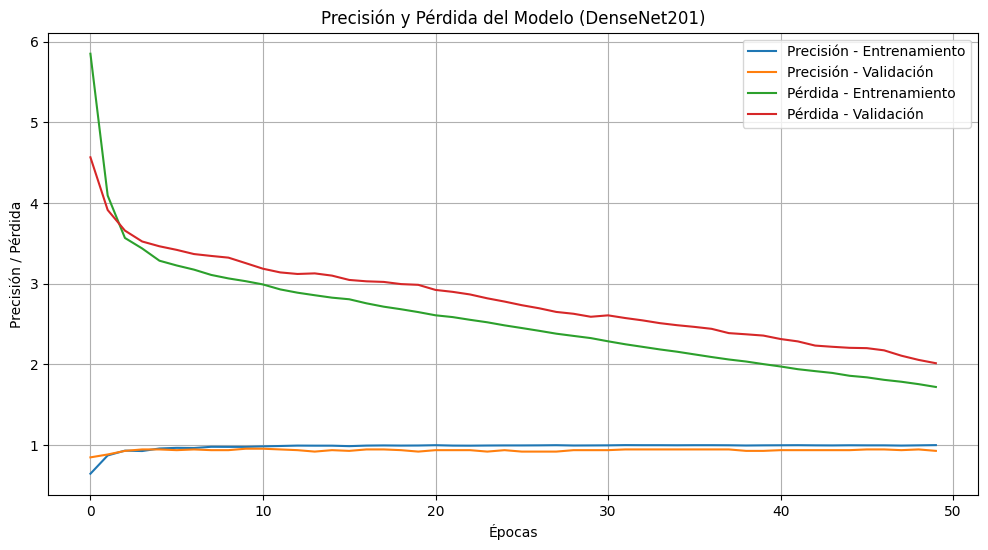

In [42]:
# Gráfica de precisión (Accuracy)
plt.figure(figsize=(10, 5))
plt.plot(result.history["accuracy"], label="Entrenamiento - Precisión")
plt.plot(result.history["val_accuracy"], label="Validación - Precisión")
plt.title("Precisión del Modelo durante el Entrenamiento y Validación (DenseNet201)")
plt.xlabel("Épocas")
plt.ylabel("Precisión")
plt.legend()
plt.grid(True)
plt.show()

# Gráfica de pérdida (Loss)
plt.figure(figsize=(10, 5))
plt.plot(result.history["loss"], label="Entrenamiento - Pérdida")
plt.plot(result.history["val_loss"], label="Validación - Pérdida")
plt.title("Pérdida del Modelo durante el Entrenamiento y Validación (DenseNet201)")
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.legend()
plt.grid(True)
plt.show()

# Gráfico combinado de precisión y pérdida
plt.figure(figsize=(12, 6))
plt.plot(result.history['accuracy'], label="Precisión - Entrenamiento")
plt.plot(result.history['val_accuracy'], label="Precisión - Validación")
plt.plot(result.history['loss'], label="Pérdida - Entrenamiento")
plt.plot(result.history['val_loss'], label="Pérdida - Validación")
plt.title("Precisión y Pérdida del Modelo (DenseNet201)")
plt.xlabel("Épocas")
plt.ylabel("Precisión / Pérdida")
plt.legend()
plt.grid(True)
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 23s 4s/step


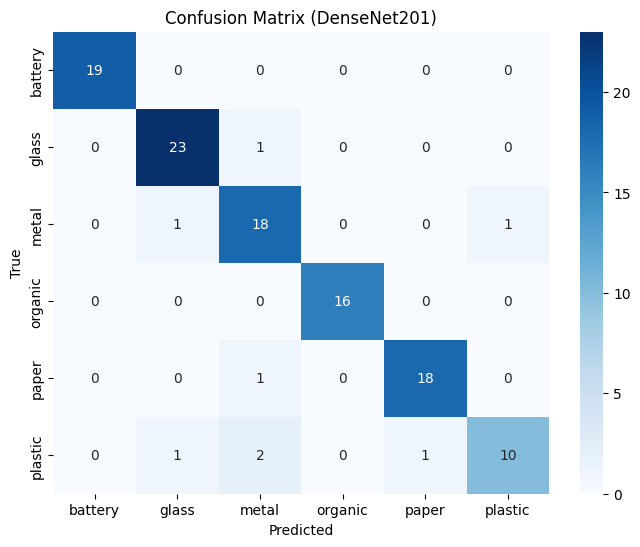

              precision    recall  f1-score   support

     battery       1.00      1.00      1.00        19
       glass       0.92      0.96      0.94        24
       metal       0.82      0.90      0.86        20
     organic       1.00      1.00      1.00        16
       paper       0.95      0.95      0.95        19
     plastic       0.91      0.71      0.80        14

    accuracy                           0.93       112
   macro avg       0.93      0.92      0.92       112
weighted avg       0.93      0.93      0.93       112



In [43]:
# Hacer predicciones con el modelo
predictions = model.predict(test_data)

# Obtener etiquetas predichas
predicted_labels = np.argmax(predictions, axis=1)

# Etiquetas verdaderas
true_labels = test_data.classes

# Matriz de confusión
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Graficar matriz de confusión con seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=test_data.class_indices.keys(),
            yticklabels=test_data.class_indices.keys())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (DenseNet201)')
plt.show()

# Reporte de clasificación
class_names = list(test_data.class_indices.keys())
print(classification_report(true_labels, predicted_labels, target_names=class_names))

### Saliency Maps para el mapa de calor


In [44]:
from tensorflow.keras import backend as K

# Función para calcular el mapa de saliencia para una clase específica usando SmoothGrad
def smooth_grad(model, img_tensor, class_index, noise_level=0.1, num_samples=20):
    """Genera un mapa de saliencia usando SmoothGrad."""
    smooth_saliency = np.zeros(img_tensor.shape[:2])
    for _ in range(num_samples):
        noise = np.random.normal(0, noise_level, img_tensor.shape)
        noisy_img = img_tensor + noise
        saliency = compute_saliency_map(model, noisy_img, class_index)
        smooth_saliency += saliency
    smooth_saliency /= num_samples  # Promedio
    return smooth_saliency

# Función básica de cálculo de saliencia (utilizada dentro de SmoothGrad)
def compute_saliency_map(model, img_tensor, label_index):
    """Calcula el mapa de saliencia para una imagen y una clase específica."""
    img_tensor = tf.convert_to_tensor([img_tensor])  # Agregar dimensión batch
    with tf.GradientTape() as tape:
        tape.watch(img_tensor)
        preds = model(img_tensor)
        loss = preds[:, label_index]
    grads = tape.gradient(loss, img_tensor)
    saliency = K.abs(grads)[0]
    saliency = np.max(saliency, axis=-1)
    return saliency  # No es necesario llamar a .numpy()

# Mostrar mapas de saliencia usando SmoothGrad para cada clase
class_labels = train_data.class_indices.keys()  # Asegúrate de tener acceso a los nombres de las clases

for class_index, class_name in enumerate(class_labels):
    # Obtener una imagen de muestra de la clase actual
    for images, labels in train_data:
        img_tensor = images[0]  # Primera imagen del lote
        label = labels[0].argmax()  # Obtener el índice de la clase (sin usar .numpy())

        # Asegurarse de que la imagen sea de la clase deseada
        if label == class_index:
            # Generar el mapa de saliencia usando SmoothGrad
            smooth_saliency = smooth_grad(model, img_tensor, class_index)

            # Normalizar la imagen para la visualización (escala [0, 1])
            img_display = (img_tensor - img_tensor.min()) / (img_tensor.max() - img_tensor.min())

            # Visualizar la imagen y el mapa de saliencia
            plt.figure(figsize=(12, 5))
            plt.subplot(1, 2, 1)
            plt.imshow(img_display)
            plt.title(f'Imagen original - Clase: {class_name}')
            plt.axis('off')

            plt.subplot(1, 2, 2)
            plt.imshow(smooth_saliency, cmap='hot')
            plt.title(f'SmoothGrad (DenseNet201) - Clase: {class_name}')
            plt.axis('off')
            plt.show()
            break  # Solo una imagen por clase

Output hidden; open in https://colab.research.google.com to view.

In [45]:
# Guardar el modelo final
model.save('/content/drive/MyDrive/Colab_Notebooks/EcoScan/wastenet_densenet201.h5')

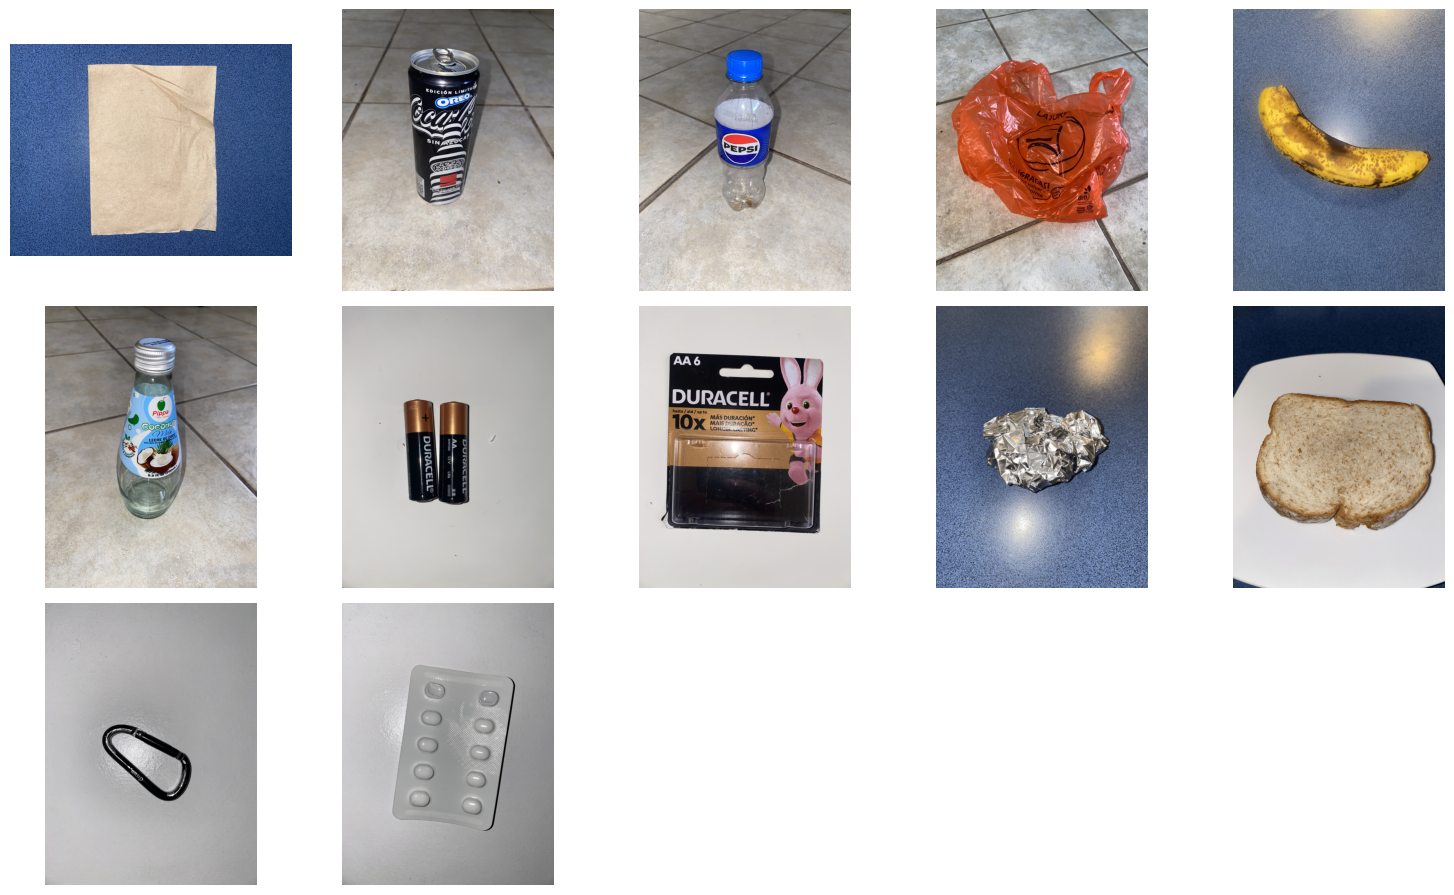

In [46]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Path a las imágenes reales para prueba
test_path = '/content/drive/MyDrive/Colab_Notebooks/EcoScan/test_real'

# Obtener los nombres de las imágenes
image_files = [os.path.join(test_path, img) for img in os.listdir(test_path)]

# Mostrar todas las imágenes
def display_images(image_paths):
    plt.figure(figsize=(15, 15))  # Ajusta el tamaño de la visualización
    for i, img_path in enumerate(image_paths):
        img = image.load_img(img_path)
        plt.subplot(5, 5, i + 1)  # Crea una grilla 5x5 (ajústalo según la cantidad de imágenes)
        plt.imshow(img)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Mostrar las imágenes del directorio
display_images(image_files)

In [47]:
import time
import numpy as np
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

# Cargar el modelo entrenado
model = load_model('/content/drive/MyDrive/Colab_Notebooks/EcoScan/wastenet_densenet201.h5')

# Diccionario para traducir las etiquetas al español
class_translation = {
    'battery': 'e-waste',
    'glass': 'vidrio',
    'metal': 'metal',
    'organic': 'orgánico',
    'paper': 'papel',
    'plastic': 'plástico'
}

# Lista para almacenar los tiempos de clasificación
classification_times = []

# Función para predecir la clase de una imagen y mostrarla junto con su etiqueta
def classify_and_display_image(image_path):
    # Cargar y mostrar la imagen
    img = image.load_img(image_path, target_size=(224, 224))
    plt.imshow(img)
    plt.axis('off')

    # Convertir la imagen a array y preprocesarla
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    # Tomar el tiempo de inicio
    start_time = time.time()

    # Hacer la predicción
    predictions = model.predict(img_array)

    # Tomar el tiempo de fin y calcular el tiempo
    end_time = time.time()
    classification_time = end_time - start_time
    classification_times.append(classification_time)

    # Obtener la clase predicha (índice) y traducirla al español
    predicted_class_idx = np.argmax(predictions[0])
    predicted_class = list(class_translation.keys())[predicted_class_idx]
    translated_class = class_translation[predicted_class]

    # Mostrar la etiqueta traducida
    plt.title(f'Clasificación (DenseNet201): {translated_class}')
    plt.show()

# Clasificar y mostrar cada imagen
for image_file in image_files:
    classify_and_display_image(image_file)

# Calcular el tiempo promedio de clasificación
average_time = np.mean(classification_times)
print(f'Tiempo promedio de clasificación por imagen (DenseNet201): {average_time:.4f} segundos')

Output hidden; open in https://colab.research.google.com to view.